## ThinkDSP

This notebook contains solutions to exercises in Chapter 3: Non-periodic signals

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [3]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline

### Exercise

Run and listen to the examples in chap03.ipynb.  In the leakage example, try replacing the Hamming window with one of the other windows provided by NumPy, and see what effect they have on leakage. 

See http://docs.scipy.org/doc/numpy/reference/routines.window.html


### Solution

Here's the leakage example:

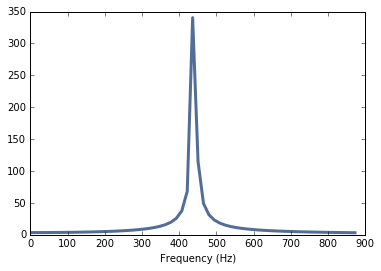

In [4]:
signal = thinkdsp.SinSignal(freq=440)
duration = signal.period * 30.25
wave = signal.make_wave(duration)
spectrum = wave.make_spectrum()

spectrum.plot(high=880)
thinkplot.config(xlabel='Frequency (Hz)')

The following figure shows the effect of 4 different windows.

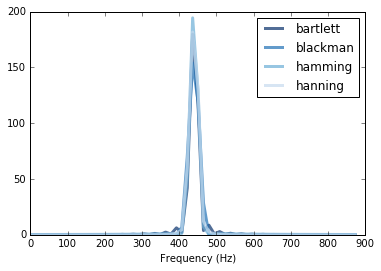

In [5]:
thinkplot.preplot(4)

for window_func in [np.bartlett, np.blackman, np.hamming, np.hanning]:
    wave = signal.make_wave(duration)
    wave.ys *= window_func(len(wave.ys))

    spectrum = wave.make_spectrum()
    spectrum.plot(high=880, label=window_func.__name__)

thinkplot.config(xlabel='Frequency (Hz)', legend=True)

All four do a good job of reducing leakage.  The Bartlett filter leaves some residual "ringing".  The Hamming filter dissipates the least amount of energy. 

### Exercise

Write a class called `SawtoothChirp` that extends `Chirp` and overrides evaluate to generate a sawtooth waveform with frequency that increases (or decreases) linearly.

In [6]:
import math
PI2 = 2 * math.pi

class SawtoothChirp(thinkdsp.Chirp):
    """Represents a sawtooth signal with varying frequency."""

    def _evaluate(self, ts, freqs):
        """Helper function that evaluates the signal.

        ts: float array of times
        freqs: float array of frequencies during each interval
        """
        dts = np.diff(ts)
        dps = PI2 * freqs * dts
        phases = np.cumsum(dps)
        phases = np.insert(phases, 0, 0)
        cycles = phases / PI2
        frac, _ = np.modf(cycles)
        ys = thinkdsp.normalize(thinkdsp.unbias(frac), self.amp)
        return ys

Here's what it sounds like.

In [7]:
signal = SawtoothChirp(start=220, end=880)
wave = signal.make_wave(duration=1, framerate=10000)
wave.apodize()
wave.make_audio()

And here's the spectrogram.

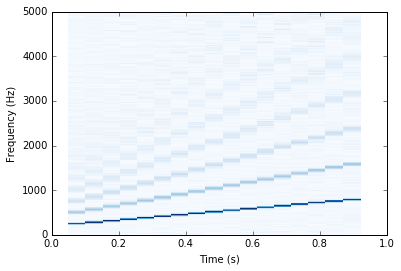

In [8]:
sp = wave.make_spectrogram(1024)
sp.plot()
thinkplot.config(xlabel='Time (s)', ylabel='Frequency (Hz)')

At a relatively low frame rate, you can see the aliased harmonics bouncing off the folding frequency.  And you can hear them as a background hiss.  If you crank up the frame rate, they go away.

By the way, if you are a fan of the original Star Trek series, you might recognize the sawtooth chirp as the red alert signal:

In [9]:
thinkdsp.read_wave('tos-redalert.wav').make_audio()

### Exercise

Make a sawtooth chirp that sweeps from 2500 to 3000 Hz, then
make a wave with duration 1 and framerate 20 kHz.  Draw a sketch of
what you think the spectrum will look like.  Then plot the
spectrum and see if you got it right.

### Solution

Since the fundamental sweeps from 2500 to 3000 Hz, I expect to see something like the
Eye of Sauron in that range.  The first harmonic sweeps from 5000 to 6000 Hz, so I expect a shorter tower in that range, like the Outhouse of Sauron.  The second harmonic sweeps from 7500 to 9000 Hz, so I expect something even shorter in that range, like the Patio of Sauron.

The other harmonics get aliased all over the place, so I expect to see some energy at all other frequencies.  This distributed energy creates some interesting sounds.

In [10]:
signal = SawtoothChirp(start=2500, end=3000)
wave = signal.make_wave(duration=1, framerate=20000)
wave.make_audio()

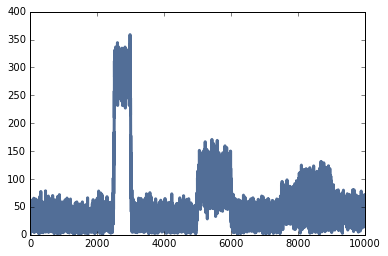

In [11]:
wave.make_spectrum().plot()

### Exercise 

In musical terminology, a “glissando” is a note that slides from one pitch to another, so it is similar to a chirp. Find or make a recording of a glissando and plot its spectrogram.  

One suggestion: George Gershwin's *Rhapsody in Blue* starts with a famous clarinet glissando; you can download a recording from http://archive.org/details/rhapblue11924.

In [12]:
wave = thinkdsp.read_wave('72475__rockwehrmann__glissup02.wav')
wave.make_audio()

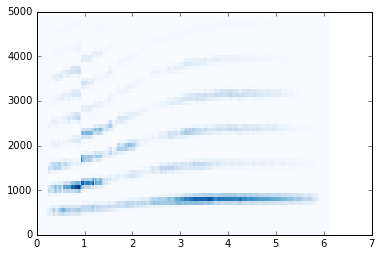

In [13]:
wave.make_spectrogram(512).plot(high=5000)

### Exercise 

A trombone player can play a glissando by extending the trombone slide while blowing continuously. As the slide extends, the total length of the tube gets longer, and the resulting pitch is inversely proportional to length.
Assuming that the player moves the slide at a constant speed, how
does frequency vary with time?  

Write a class called `TromboneGliss` that extends `Chirp` and
provides `evaluate`.  Make a wave that simulates a trombone
glissando from F3 down to C3 and back up to F3.  C3 is 262 Hz; F3 is
349 Hz.

Plot a spectrogram of the resulting wave.  Is a trombone glissando
more like a linear or exponential chirp?

In [14]:
class TromboneGliss(thinkdsp.Chirp):
    """Represents a trombone-like signal with varying frequency."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts)-1)
        freqs = 1 / lengths
        return self._evaluate(ts, freqs)

Here's the first part of the wave:

In [15]:
low = 262
high = 349
signal = TromboneGliss(high, low)
wave1 = signal.make_wave(duration=1)
wave1.apodize()
wave1.make_audio()

And the second part:

In [16]:
signal = TromboneGliss(low, high)
wave2 = signal.make_wave(duration=1)
wave2.apodize()
wave2.make_audio()

Putting them together:

In [17]:
wave = wave1 | wave2
wave.make_audio()

Here's the spectrogram:

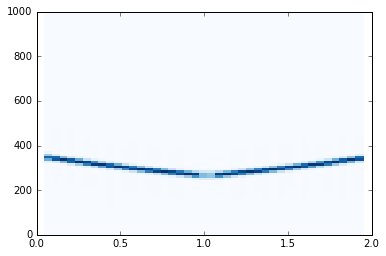

In [18]:
sp = wave.make_spectrogram(1024)
sp.plot(high=1000)

### Exercise

Make or find a recording of a series of vowel sounds and look at the
spectrogram.  Can you identify different vowels?

In [19]:
wave = thinkdsp.read_wave('87778__marcgascon7__vocals.wav')
wave.make_audio()

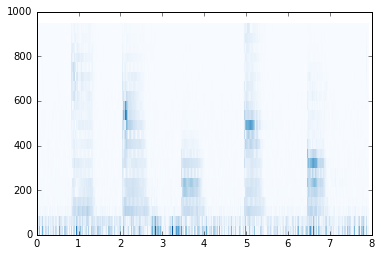

In [20]:
wave.make_spectrogram(1024).plot(high=1000)

The stripe across the bottom is probably background noise.  The peaks in the spectrogram are called "formants".

In general, vowel sounds are distinguished by the amplitude ratios of the first two formants relative to the fundamental.  For more, see https://en.wikipedia.org/wiki/Formant

We can see the formats more clearly by selecting a segment during 'ah'.

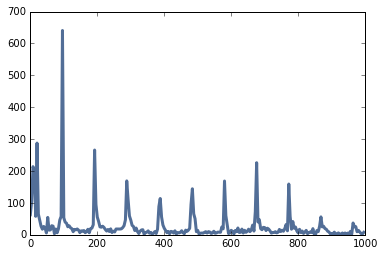

In [21]:
high = 1000
thinkplot.preplot(5)

segment = wave.segment(start=1, duration=0.25)
segment.make_spectrum().plot(high=high)

The fundamental is near 100 Hz.  The next highest peaks are at 200 Hz and 700 Hz.  People who know more about this than I do can identify vowels by looking at spectrums, but I can't.

The 'eh' segment has a high-amplitude formant near 500 Hz.

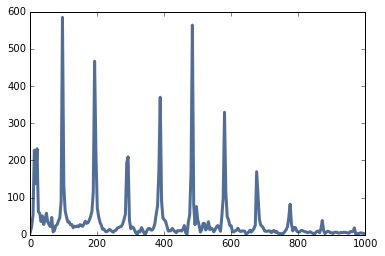

In [22]:
segment = wave.segment(start=2.2, duration=0.25)
segment.make_spectrum().plot(high=high)

The 'ih' segment has no high frequency components.

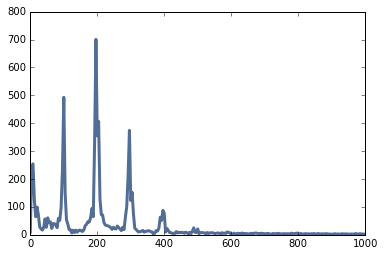

In [23]:
segment = wave.segment(start=3.5, duration=0.25)
segment.make_spectrum().plot(high=high)

The 'oh' segment has a high-amplitude formant near 500 Hz, even higher than the fundamental.

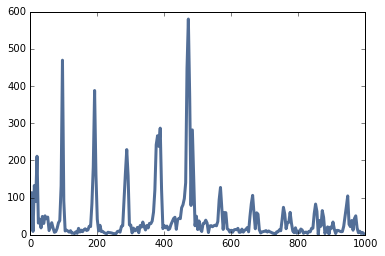

In [24]:
segment = wave.segment(start=5.1, duration=0.25)
segment.make_spectrum().plot(high=high)

The 'oo' segment has a high-amplitude formant near 300 Hz and no high-frequency components

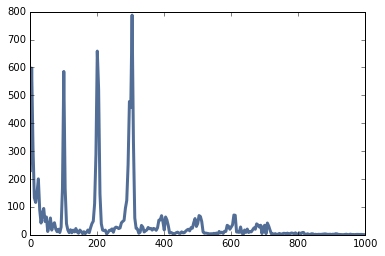

In [25]:
segment = wave.segment(start=6.5, duration=0.25)
segment.make_spectrum().plot(high=high)